In [1]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit
import jaxley as jx
%matplotlib inline
_ = np.random.seed(0)
from reaching_task import Reaching
from jaxley_rnn import build_rnn
from jax import jit, vmap, value_and_grad
from jax.tree_util import tree_map
import optax
from jaxley.optimize.utils import l2_norm
from train_utils import simulate, init_opt, predict, accuracy, ce


In [2]:
seed = 1
g_scaling = 100_000 / 2 / np.pi / 10.0 / 1.0
dt = .025
n_classes = 6
#sync_wandb=True
#sav/e_dir = "/mnt/qb/work/macke/mpals85/task_mods/"
#save_dir = "/home/matthijs/jaxley_experiments/nex/memory/models/"



#constraints
lowers = {"input_weights": 0, "IonotropicSynapse_gS": 0, "IonotropicSynapse_k_minus": 1/20, "v": -120.0}
uppers= {"input_weights": 4, "IonotropicSynapse_gS": None, "IonotropicSynapse_k_minus": 2.0, "v":0}

training_params={
    "lr":0.01,
    "lr_end":0.0001,
    "delay_step":4000, 
    "lowers":lowers,
    "uppers":uppers,
    "max_epochs":1250,
    "loss_threshold":.65,
    "acc_threshold":.95,
    "train_k_minus":True,
    'checkpoint_levels':2,
}

#  task params (in ms)


trial_len = 20
onset = [5,6]
stim_dur = [10,11]
delay_dur = [1,2]
n_stim = n_classes
batch_size = 64

task_params={
        'trial_len' : int(trial_len / dt),          # total trial length in steps
        'onset'     : (int(onset[0] / dt), int(onset[1] / dt)),    # stimulus onset range in steps
        'stim_dur'  : (int(stim_dur[0] / dt), int(stim_dur[1] / dt)),  # stimulus duration range in steps
        'delay_dur' : (int(delay_dur[0] / dt), int(delay_dur[1] / dt)), # delay duration range in steps
        'n_stim'    : n_stim,                       # number of unique stimuli
        'batch_size': batch_size                    # batch size for get_batch
}


56 [56, 57] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
15.333333333333334
828
54
conn probability recurrence: 0.2839506172839506
EIratio:4.4
Normaliser: 0.5267085409714959
Spectral radius recurrence: 0.0007991130800482155
Expected gain: 0.0005654866776461627
Leak out
Leak out
Leak out
Leak out
Leak out
Leak out


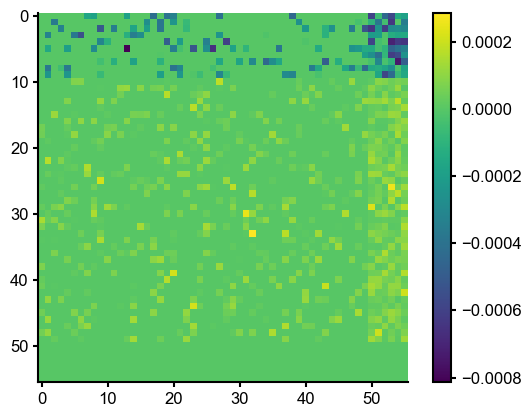

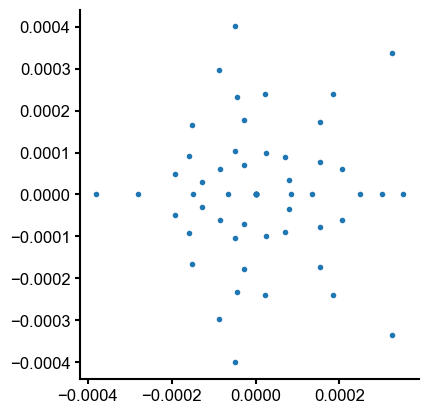

In [3]:

# Initial RNN params
RNN_params = {
    "RNN_seed":seed,
    "seed":seed,
    "n_rec":50,
    "n_inh":10,
    "n_out":n_classes,
    "init_gain": .9/g_scaling,
    "out_scale":.2,
    "inp_scale":.5,
    "in_conn_prob":.1,
    "out_conn_prob":1,
    "rec_conn_prob":.05,
    "k_minus":1,
    "out_k_minus":.1,
    "n_stim":n_stim,
}


net, conn_matrix,input_weights,input_weights_mask = build_rnn(RNN_params,verbose=False)


im = plt.imshow(conn_matrix)
plt.colorbar(im)
plt.figure()
ev = np.linalg.eigvals(conn_matrix)
plt.scatter(ev.real, ev.imag)
plt.gca().set_aspect("equal")  # , adjustable='box')

In [4]:
# needed!
#net.delete_stimuli()
#net.delete_recordings()


In [5]:
task = Reaching(task_params=task_params,
)

In [6]:
import jaxley.optimize.transforms as jt

In [7]:
input_weights_min = training_params['lowers']['input_weights']
input_weights_max = training_params['uppers']['input_weights']
IonotropicSynapse_k_minus_min = training_params['lowers']['IonotropicSynapse_k_minus']
IonotropicSynapse_k_minus_max = training_params['uppers']['IonotropicSynapse_k_minus']


In [8]:
tf = jx.ParamTransform([{"input_weights": jt.SigmoidTransform(input_weights_min, input_weights_max)},
                        {"IonotropicSynapse_gS": jt.SoftplusTransform(0)},
                        {"IonotropicSynapse_k_minus" : jt.SigmoidTransform(IonotropicSynapse_k_minus_min, IonotropicSynapse_k_minus_max)}])


def label_params(opt_params):
    """Assign parameter group labels for optax.multi_transform."""
    def label_fn(param_dict):
        if "input_weights" in param_dict:
            return "weights"
        if "IonotropicSynapse_gS" in param_dict:
            return "gS"
        if "IonotropicSynapse_k_minus" in param_dict:
            return "kminus"
        if "v" in param_dict:
            return "v"
        return "other"
    return jax.tree_util.tree_map(label_fn, opt_params)

def init_opt(opt_params, base_lr):
    # Per-group optimizers
    transforms = {
        "weights": optax.adam(base_lr * 1.0),
        "gS": optax.adam(base_lr * 0.01),     # much smaller LR
        "kminus": optax.adam(base_lr * 1.0),
        "v": optax.adam(base_lr * 0.1),
        "other": optax.adam(base_lr),         # fallback
    }

    labels = label_params(opt_params)

    gradient_transform = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.multi_transform(transforms, labels),
    )
    opt_state = gradient_transform.init(opt_params)
    return opt_state, gradient_transform


In [9]:
from jax.flatten_util import ravel_pytree


In [10]:
# make network trainable
net.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")
if training_params['train_k_minus']:
    net.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_k_minus")
params = net.get_parameters()

params = input_weights + params
#init_params = params.copy()
#init_params.append({'conn_matrix':conn_matrix})

opt_params = tf.inverse(params)
net.delete_recordings()

# record from readouts
for i in range(RNN_params['n_out']):
    net.cell([RNN_params['n_rec']+i]).branch(0).comp(0).record(verbose=False)
# Create simulation / training functions
levels = training_params['checkpoint_levels']



Number of newly added trainable parameters: 828. Total number of trainable parameters: 828
Number of newly added trainable parameters: 828. Total number of trainable parameters: 1656


In [11]:
net.delete_recordings()
for i in range(RNN_params['n_rec']+RNN_params['n_out']):
    net.cell(i).branch(0).comp(0).record(verbose=False)

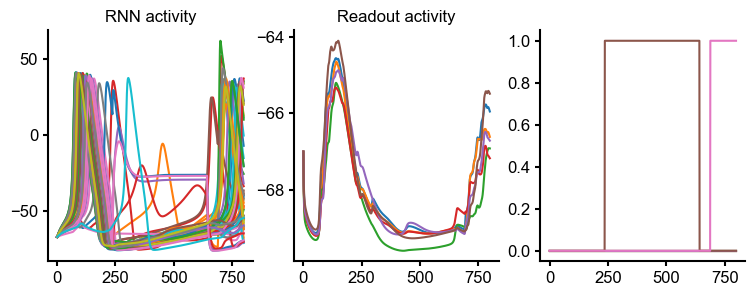

In [12]:
stim, target, mask = task.get_batch()
fig,ax = plt.subplots(1,3,figsize=(9,3))
for i in range(1):
    params=tf.forward(opt_params)
    v= simulate(params, stim[i],input_weights_mask,net,dt=dt,levels=levels)
    ax[0].plot(v[:RNN_params['n_rec']].T)#,aspect='auto')
    ax[1].plot(v[RNN_params['n_rec']:].T)
    ax[2].plot(stim[i])
    ax[0].set_title('RNN activity')
    ax[1].set_title('Readout activity')

ax[1].spines[['top','right']].set_visible(False)


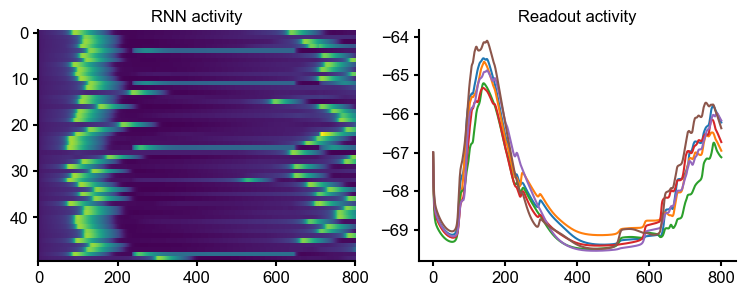

In [13]:
stim, target, mask = task.get_batch()
fig,ax = plt.subplots(1,2,figsize=(9,3))
for i in range(1):
    params = tf.forward(opt_params)
    v= simulate(params, stim[i],input_weights_mask,net,dt=dt,levels=levels)
    ax[0].imshow(v[:RNN_params['n_rec']],aspect='auto')
    ax[1].plot(v[RNN_params['n_rec']:].T)
    ax[0].set_title('RNN activity')
    ax[1].set_title('Readout activity')
ax[1].spines[['top','right']].set_visible(False)


In [14]:
net.delete_recordings()
for i in range(RNN_params['n_out']):
    net.cell([RNN_params['n_rec']+i]).branch(0).comp(0).record(verbose=False)

In [15]:
def loss_fn(opt_params, stim, label, mask):
    """Compute loss and accuracy for optimization.
    Args:
        opt_params: parameters in the transformed space
        stim:  (T-1, n_classes+1)
        label: (T, n_classses)
        mask:  (T, 1)
    """
#

    params = tf.forward(opt_params)
    pred = predict(params, stim, input_weights_mask,net, dt=dt, levels=levels)
    loss_val = ce(pred, label, mask)
    acc_val = accuracy(pred, label, mask)
    return loss_val, acc_val


vmapped_loss_fn = vmap(loss_fn, in_axes=(None, 0, 0, 0))

def batched_loss_fn(params, stims, labels, masks):
    """mean loss over batch of trials"""
    all_loss_vals,all_accs = vmapped_loss_fn(params, stims, labels, masks)
    return jnp.mean(all_loss_vals),jnp.mean(all_accs)

grad_fn = jit(value_and_grad(batched_loss_fn, argnums=0, has_aux=True))
#grad_fn = (value_and_grad(batched_loss_fn, argnums=0, has_aux=True))

In [ ]:

opt_state, optimizer = init_opt(opt_params, lr = training_params['lr'], lr_end=training_params['lr_end'])

for i in range(training_params['max_epochs']):
    stim, target, mask = task.get_batch()
    #with jax.checking_leaks():
    (l,a), g = grad_fn(opt_params, stim[:,1:], target, mask)
    flat_g, _ = ravel_pytree(g)
    print("Global grad norm:", jnp.linalg.norm(flat_g))
    if i % 1 == 0:
        print(f"it {i}, loss {l}, acc {a}")
        
    if np.isnan(l):
        print("loss is nan")
        break

    updates, opt_state = optimizer.update(g, opt_state)
    opt_params = optax.apply_updates(opt_params, updates)



Global grad norm: 0.183745837182804
it 0, loss 1.1485729226677694, acc 0.15066000819206238
param: masked input_weights, grad_norm: 0.07699075083599806, param_norm: 18.283127463944556, min_param_val: -5.347825850386512, max_param_val: -1.9874793800470165
param: dict_keys(['IonotropicSynapse_gS']), grad_norm: 0.16599648885149923, param_norm: 286.07046567243685, min_param_val: -15.673452417434929, max_param_val: -7.113242407754994
param: dict_keys(['IonotropicSynapse_k_minus']), grad_norm: 0.016736865199100788, param_norm: 1.4759639889502503, min_param_val: -0.05129329438755069, max_param_val: -0.05129329438755069
Global grad norm: 0.2119283862330471
it 1, loss 1.1009717515788136, acc 0.14832660555839539
param: masked input_weights, grad_norm: 0.11102361516082024, param_norm: 18.29464687988972, min_param_val: -5.33782585293492, max_param_val: -1.9974793750785775
param: dict_keys(['IonotropicSynapse_gS']), grad_norm: 0.17945090443074324, param_norm: 286.09012054026954, min_param_val: -15.6